In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

MODEL_DIR = "."

tokenizer = T5Tokenizer.from_pretrained(MODEL_DIR)
model = T5ForConditionalGeneration.from_pretrained(MODEL_DIR)
model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [ ]:
import pandas as pd


DATA_PATH = "../../data/grammar_valid.csv"

def load_data_from_csv(path, max_samples=1000):
    df = pd.read_csv(path)
    
    df = df.dropna(subset=["source", "target"])
    df = df.sample(n=min(max_samples, len(df)), random_state=4011)
    
    pairs = list(zip(df["source"].tolist(), df["target"].tolist()))
    return pairs

pairs = load_data_from_csv(DATA_PATH, max_samples=1000)
len(pairs)

1000

In [3]:
def predict_one(sentence):
    input_text = "grammar: " + sentence

    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_length=128,
            num_beams=4
        )

    return tokenizer.decode(output[0], skip_special_tokens=True)

In [4]:
from tqdm import tqdm

y_true = []
y_pred = []

examples = []

for incorrect, target in tqdm(pairs):
    pred = predict_one(incorrect)

    is_correct = int(pred.strip() == target.strip())

    y_true.append(1)
    y_pred.append(is_correct)

    if len(examples) < 5:
        examples.append((incorrect, target, pred))


100%|██████████| 1000/1000 [09:38<00:00,  1.73it/s]


In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="binary", pos_label=1, zero_division=0
)

print("Confusion Matrix")
print(cm)
print("\n")
print(f"Accuracy: {acc * 100}%")
print(f"Precision: {prec * 100}%")
print(f"Recall: {rec * 100}%")
print(f"F1 Score: {f1 * 100}%")
print("\n")
print("Classification Report")
print(classification_report(y_true, y_pred, zero_division=0))


Confusion Matrix
[[  0   0]
 [875 125]]


Accuracy: 12.5%
Precision: 100.0%
Recall: 12.5%
F1 Score: 22.22222222222222%


Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.12      0.22      1000

    accuracy                           0.12      1000
   macro avg       0.50      0.06      0.11      1000
weighted avg       1.00      0.12      0.22      1000



#### The Seq2Seq model can not provide exact same answer as the target. Every single words, expression, and even spaces used should be equal to the target and then it will count as correct. Hence, this is not a good way to evaluate the model

## chrF Evaluation

**chrF is a character-based F-score**
- Less strict then the exact match accuracy evaluation method.

1. Divide the sentence into character by character.
2. Compare the similarity of character n-grams of the target (gold) and the prediction.
3. Computes Precision, Recall, and F-score over the character n-grams

In [6]:
y_true = []
y_pred = []

all_targets = []
all_preds = []

examples = []

for incorrect, target in pairs:
    pred = predict_one(incorrect)

    target_clean = target.strip()
    pred_clean = pred.strip()

    is_correct = int(pred_clean == target_clean)

    y_true.append(1)
    y_pred.append(is_correct)

    all_targets.append(target_clean)
    all_preds.append(pred_clean)

    if len(examples) < 5:
        examples.append((incorrect, target_clean, pred_clean))
len(all_targets), len(all_preds)

(1000, 1000)

In [7]:
from sacrebleu.metrics import CHRF

chrf_metric = CHRF()
chrf_score = chrf_metric.corpus_score(all_preds, [all_targets])

print("chrF score:", chrf_score.score)

chrF score: 88.05925526956031


In [8]:
sentence_chrf_scores = []

for pred, target in zip(all_preds, all_targets):
    s = chrf_metric.sentence_score(pred, [target]).score
    sentence_chrf_scores.append(s)

In [9]:
import numpy as np

threshold = 70.0 # Score threshold for good and bad correction

y_true_chr = np.ones(len(sentence_chrf_scores), dtype=int)
y_pred_chr = (np.array(sentence_chrf_scores) >= threshold).astype(int)

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

cm_chr = confusion_matrix(y_true_chr, y_pred_chr, labels=[0, 1])
acc_chr = accuracy_score(y_true_chr, y_pred_chr)
prec_chr = precision_score(y_true_chr, y_pred_chr, pos_label=1, zero_division=0)
rec_chr = recall_score(y_true_chr, y_pred_chr, pos_label=1, zero_division=0)
f1_chr = f1_score(y_true_chr, y_pred_chr, pos_label=1, zero_division=0)

print("chrF-based Confusion Matrix")
print(cm_chr)
print("\n")
print("chrF-based Metrics")
print(f"Accuracy: {acc_chr * 100}%")
print(f"Precision: {prec_chr * 100}%")
print(f"Recall: {rec_chr * 100}%")
print(f"F1 Score: {f1_chr * 100}%")
print("\n")
print("chrF-based Classification Report")
print(classification_report(y_true_chr, y_pred_chr, zero_division=0))

chrF-based Confusion Matrix
[[  0   0]
 [142 858]]


chrF-based Metrics
Accuracy: 85.8%
Precision: 100.0%
Recall: 85.8%
F1 Score: 92.35737351991389%


chrF-based Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.86      0.92      1000

    accuracy                           0.86      1000
   macro avg       0.50      0.43      0.46      1000
weighted avg       1.00      0.86      0.92      1000



**According to Confusion Matrix:**
858 corrections were adove 70 points, good correction
142 corrections were below 70 points.

**chrF-based Accuracy:**
85.8%: Which means 8~9 sentences are accurately corrected out of 10 sentences.

**chrF-based F1-score:**
92.35%: Overall have high precision and high recall in correction.

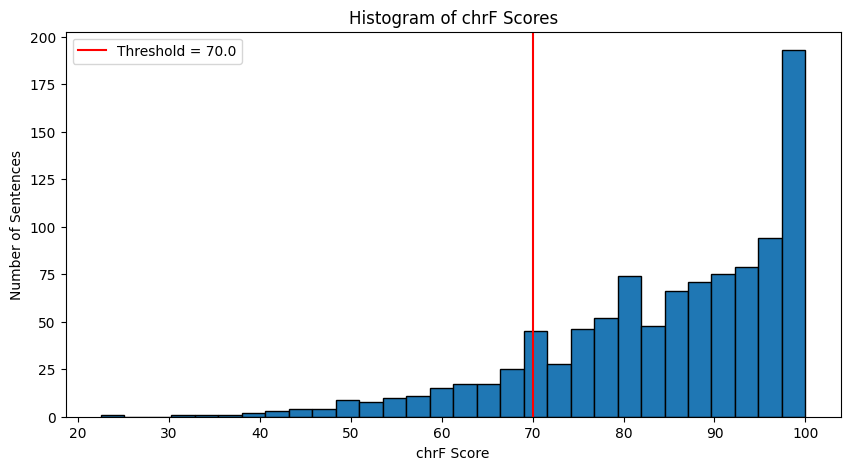

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(sentence_chrf_scores, edgecolor='black', bins=30)
plt.axvline(threshold, color='red', label=f"Threshold = {threshold}")

plt.title("Histogram of chrF Scores")
plt.xlabel("chrF Score")
plt.ylabel("Number of Sentences")
plt.legend()
plt.show()

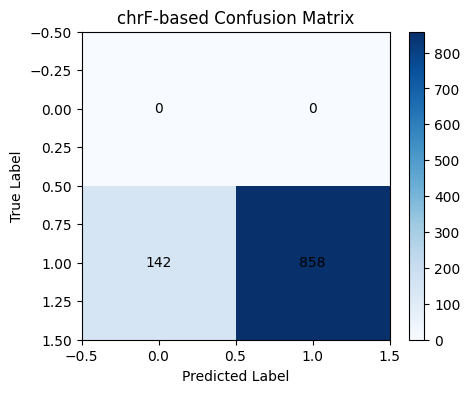

In [12]:
cm_chr = confusion_matrix(y_true_chr, y_pred_chr, labels=[0, 1])

plt.figure(figsize=(5, 4))
plt.imshow(cm_chr, cmap='Blues')
plt.title("chrF-based Confusion Matrix")
plt.colorbar()

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_chr[i, j], ha='center', va='center')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [13]:
import pandas as pd

df_example = pd.DataFrame({
    "source": [s for s, _ in pairs],
    "target(gold)": all_targets,
    "prediction": all_preds,
    "chrF score": sentence_chrf_scores
})

print("Highest chrF score Examples")
display(df_example.sort_values("chrF score", ascending=False).head(5))

print("Lowest chrF score Examples")
display(df_example.sort_values("chrF score", ascending=True).head(5))

Highest chrF score Examples


,source,target(gold),prediction,chrF score
0,to written dialy everyday: ),to write a daily diary every day: ),to write a daily diary every day: ),100.0
268,i would like to memorize all in a few days.,i would like to memorize everything in a few d...,i would like to memorize everything in a few d...,100.0
768,"i write a blog, join in sl.","i write a blog, and join in with sl.","i write a blog, and join in with sl.",100.0
763,"chinese characters, however, take longer time ...","chinese characters, however, take longer to wr...","chinese characters, however, take longer to wr...",100.0
762,"third day, i went sightseeing aroud guam.","on the third day, i went sightseeing around guam.","on the third day, i went sightseeing around guam.",100.0


Lowest chrF score Examples


,source,target(gold),prediction,chrF score
10,why was became to were?,why did was become were?,why was it became to be?,22.527464
641,my beautiful mood has gone.,my good mood had gone.,my beautiful mood has gone away.,31.750228
257,but she always not sees me.,but she never sees me.,but she does not always see me.,34.067138
165,i love you bether than me.,i love you better than you love me.,i love you more than me.,35.923072
112,"so, i staid as result as 4 hours.","so, i stood in as the result of 4 hours.","so, i watched as a result for 4 hours.",38.686047
